# INM706 Coursework
### Aaron Mir (Student Number: 160001207)

MIMIC-III is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The MIMIC-III Clinical Database is available on PhysioNet (doi: 10.13026/C2XW26). Though deidentified, MIMIC-III contains detailed information regarding the care of real patients, and as such requires credentialing before access. To allow researchers to ascertain whether the database is suitable for their work, we have manually curated a demo subset, which contains information for 100 patients also present in the MIMIC-III Clinical Database. Notably, the demo dataset does not include free-text notes.

The demo dataset contains all intensive care unit (ICU) stays for 100 patients. These patients were selected randomly from the subset of patients in the dataset who eventually die. Consequently, all patients will have a date of death (DOD). However, patients do not necessarily die during an individual hospital admission or ICU stay.

Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID.
Each row of this table contains a unique HADM_ID, which represents a single patient’s admission to the hospital. HADM_ID ranges from 1000000 - 1999999. It is possible for this table to have duplicate SUBJECT_ID, indicating that a single patient had multiple admissions to the hospital. The ADMISSIONS table can be linked to the PATIENTS table using SUBJECT_ID.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import torch 
import torch.nn as nn
from torch.autograd import Variable

In [45]:
admission_data = pd.read_csv('data\\ADMISSIONS.csv')

In [46]:
admission_data

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,41055,44083,198330,2112-05-28 15:45:00,2112-06-07 16:50:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,2112-05-28 13:16:00,2112-05-28 17:30:00,PERICARDIAL EFFUSION,0,1
125,41070,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,2178-05-14 17:37:00,2178-05-14 22:08:00,ALTERED MENTAL STATUS,1,1
126,41087,44212,163189,2123-11-24 14:14:00,2123-12-30 14:31:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,NaN,NaN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,0,1
127,41090,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,2180-07-19 04:50:00,2180-07-19 08:23:00,BRADYCARDIA,0,1


In [49]:
admission_data.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')

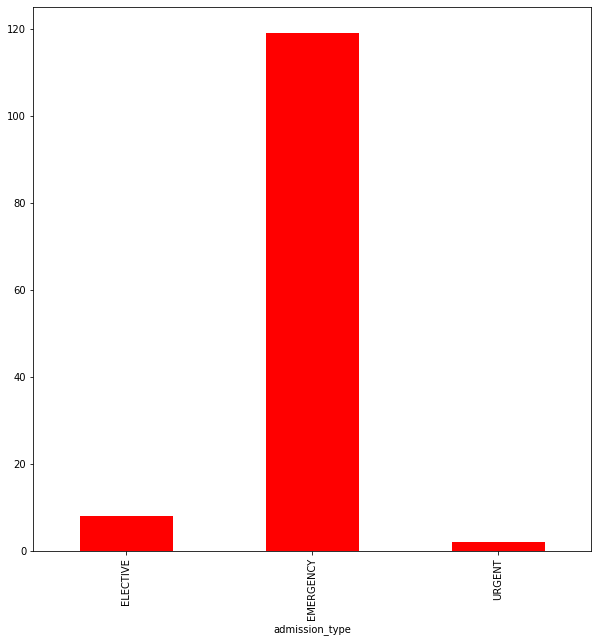

In [59]:
fig = plt.figure(figsize=(10,10))
admission_data.groupby(['admission_type']).size().plot.bar(color = 'red');

In [63]:
admission_data.admittime = pd.to_datetime(admission_data.admittime, format = '%Y-%m-%d %H:%M:%S')
admission_data.dischtime = pd.to_datetime(admission_data.dischtime, format = '%Y-%m-%d %H:%M:%S')
admission_data.deathtime = pd.to_datetime(admission_data.deathtime, format = '%Y-%m-%d %H:%M:%S')

In [65]:
print('NULL date entries in admission column:', admission_data.admittime.isnull().sum())
print('NULL date entries in discharge column:', admission_data.dischtime.isnull().sum())

NULL date entries in admission column: 0
NULL date entries in discharge column: 0


In [53]:
diagnosis_code_data = pd.read_csv('data\\DIAGNOSES_ICD.csv')

In [54]:
diagnosis_code_data

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731
...,...,...,...,...,...
1756,397673,44228,103379,7,1975
1757,397674,44228,103379,8,45182
1758,397675,44228,103379,9,99592
1759,397676,44228,103379,10,2449


In [8]:
diagnosis_data = pd.read_csv('data\\D_ICD_DIAGNOSES.csv')

In [9]:
diagnosis_data

,row_id,icd9_code,short_title,long_title
0,1,01716,Erythem nod tb-oth test,Erythema nodosum with hypersensitivity reactio...
1,2,01720,TB periph lymph-unspec,"Tuberculosis of peripheral lymph nodes, unspec..."
2,3,01721,TB periph lymph-no exam,"Tuberculosis of peripheral lymph nodes, bacter..."
3,4,01722,TB periph lymph-exam unk,"Tuberculosis of peripheral lymph nodes, bacter..."
4,5,01723,TB periph lymph-micro dx,"Tuberculosis of peripheral lymph nodes, tuberc..."
...,...,...,...,...
14562,14563,V8712,Contact/exposure benzene,Contact with and (suspected) exposure to benzene
14563,14564,V8719,Cont/exp haz aromat NEC,Contact with and (suspected) exposure to other...
14564,14565,V872,Cont/exp hazard chem NEC,Contact with and (suspected) exposure to other...
14565,14566,V8731,Contact/exposure mold,Contact with and (suspected) exposure to mold


In [10]:
patient_data = pd.read_csv('data\\PATIENTS.csv')

In [11]:
patient_data

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1
...,...,...,...,...,...,...,...,...
95,31838,44083,M,2057-11-15 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00,1
96,31853,44154,M,1878-05-14 00:00:00,2178-05-15 00:00:00,2178-05-15 00:00:00,2178-05-15 00:00:00,1
97,31867,44212,F,2078-06-16 00:00:00,2124-01-29 00:00:00,NaN,2124-01-29 00:00:00,1
98,31870,44222,M,2107-06-27 00:00:00,2182-08-03 00:00:00,2182-08-03 00:00:00,NaN,1


In [ ]:
# check if GPU is available
if(torch.cuda.is_available()):
    print('Training on GPU!')
else: 
    print('Training on CPU!')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
seqs = np.array(pickle.load(open('data\\ADMISSIONS.csv ','rb')))

In [12]:
mimic = pd.read_csv('data2\\MIMIC-III-Final.csv')

In [32]:
mimic.head()

,Unnamed: 0,TEXT,HADM_ID,ICD9_CODE
0,0,{Admission Date: [**2117-9-11**] ...,100001.0,"['25013', '3371', '5849', '5780', 'V5867', '25..."
1,1,{Admission Date: [**2150-4-17**] ...,100003.0,"['53100', '2851', '07054', '5715', '45621', '5..."
2,2,{Admission Date: [**2108-4-6**] Dischar...,100006.0,"['49320', '51881', '486', '20300', '2761', '78..."
3,3,{Admission Date: [**2145-3-31**] ...,100007.0,"['56081', '5570', '9973', '486', '4019']"
4,4,{Admission Date: [**2162-5-16**] ...,100009.0,"['41401', '99604', '4142', '25000', '27800', '..."


In [42]:
print(mimic.loc[1,'TEXT'])

{Admission Date:  [**2150-4-17**]              Discharge Date:   [**2150-4-21**]

Date of Birth:  [**2090-5-19**]             Sex:   M

Service: MEDICINE

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 12174**]
Chief Complaint:
coffee ground emesis

Major Surgical or Invasive Procedure:
EGD
Right IJ CVL


History of Present Illness:
Mr. [**Known lastname 52368**] is a 59M w HepC cirrhosis c/b grade I/II esophageal
varices and portal gastropathy (last EGD [**3-/2150**]), who p/w
coffee-ground emesis and melena x2 days.
.
Pt was in his USOH until about 2-3 days PTA, when he began
experiencing intermittent nausea. He had 2-3 episodes of
coffee-ground emesis and 1 episode of tarry black stool in the
morning of admission. He reports some lightheadedness which is
not new, but denies frank hematemesis, BRBPR, abdominal pain,
fever, chills, significant increases in his abdominal girth. He
denies drinking or medication non-compliance. He also re

## Data pre-processing